In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.utils import shuffle as sklearnShuffle
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, GlobalAveragePooling2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dropout
from keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from numpy.random import shuffle
from keras.models import Model
from random import randint
from keras.models import load_model

# Visualizations will be shown in the notebook.
%matplotlib inline


Using TensorFlow backend.


In [2]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = batch_sample[0]
                if 'flipped' in name and 'translated' in name:
                    #rand = float(name.split('_')[0])
                    side = name.split('_')[0]
                    name = name.replace(side +'_flipped_', '')
                    image = imread("./data/IMG/" + name)
                    image = np.fliplr(image)
                    if side == 'ltranslated':
                        image = translation(image, -160)
                    if side == 'rtranslated':
                        image = translation(image, 160)
                elif 'flipped' in name:
                    name = name.replace('flipped_', '')
                    image = imread("./data/IMG/" + name)
                    image = np.fliplr(image)
                elif 'translated' in name:
                    #rand = float(name.split('_')[0])
                    side = name.split('_')[0]
                    name = name.replace(side + '_', '')
                    image = imread("./data/IMG/" + name)
                    if side == 'ltranslated':
                        image = translation(image, -160)
                    if side == 'rtranslated':
                        image = translation(image, 160)
                else:
                    image = imread("./data/IMG/" + name)
                #image = cv2.resize(image, (128,128))
                angle = float(batch_sample[1])
                images.append(image)
                angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearnShuffle(X_train, y_train)

In [3]:
def generator_predict(samples, batch_size=128):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            for batch_sample in batch_samples:
                name = batch_sample[0]
               
                if 'flipped' in name and 'translated' in name:
                    #rand = float(name.split('_')[0])
                    side = name.split('_')[0]
                    name = name.replace(side+'_flipped_', '')
                    image = imread("./data/IMG/" + name)
                    image = np.fliplr(image)
                    if side == 'ltranslated':
                        image = translation(image, -160)
                    if side == 'rtranslated':
                        image = translation(image, 160)
                elif 'flipped' in name:
                    name = name.replace('flipped_', '')
                    image = imread("./data/IMG/" + name)
                    image = np.fliplr(image)
                elif 'translated' in name:
                    #rand = float(name.split('_')[0])
                    side = name.split('_')[0]
                    name = name.replace(side+'_', '')
                    image = imread("./data/IMG/" + name)
                    if side == 'ltranslated':
                        image = translation(image, -160)
                    if side == 'rtranslated':
                        image = translation(image, 160)
                else:
                    image = imread("./data/IMG/" + name)
                
                #image = cv2.resize(image, (128,128))
                images.append(image)
                
            images = np.array(images)
            yield images
            

In [4]:
def samples_view(samples):
    bins = [(i - 0.5)/100 for i in range(-100, 102)]
    plt.figure(figsize=(5, 5))
    plt.hist(samples[:,1].astype(float), bins, facecolor = 'b', label = 'Training Label')
    plt.title('Samples distribution')
    plt.xlabel('steering angle')
    plt.show()
    print('shape of sample set: {}'.format(samples.shape))
    print('Samples labeling - mean: {}, std: {}, min: {}, max: {}'.format(samples[:,1].astype(float).mean(),
                                                                      samples[:,1].astype(float).std(),
                                                                      samples[:,1].astype(float).min(),
                                                                      samples[:,1].astype(float).max()))

In [5]:
def split_samples(samples):
    bins = [(i - 0.5)/100 for i in range(-100, 102)]
    train_samples, validation_samples = train_test_split(samples, test_size=0.1, random_state=0)
    fig, (train, validation) = plt.subplots(ncols=2, figsize=(10, 4))
    train.hist(train_samples[:,1].astype(float), bins, color = 'b')
    train.set_title('train labels')
    validation.hist(validation_samples[:,1].astype(float), bins, color = 'g')
    validation.set_title('validation labels')
    plt.show()
    print('shape of train sample set: {}'.format(train_samples.shape))
    print('shape of validation sample set: {}'.format(validation_samples.shape))
    print('Train labeling - mean: {}, std: {}, min: {}, max: {}'.format(train_samples[:,1].astype(float).mean(),
                                                                      train_samples[:,1].astype(float).std(),
                                                                      train_samples[:,1].astype(float).min(),
                                                                      train_samples[:,1].astype(float).max()))
    print('Validation labeling - mean: {}, std: {}, min: {}, max: {}'.format(validation_samples[:,1].astype(float).mean(),
                                                                      validation_samples[:,1].astype(float).std(),
                                                                      validation_samples[:,1].astype(float).min(),
                                                                      validation_samples[:,1].astype(float).max()))
    
    return train_samples, validation_samples

In [6]:
### plot the training and validation loss for each epoch
def training_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

In [7]:
def evaluate(validation_samples):
    validation_generator = generator(validation_samples, batch_size=32)
    val_loss = model.evaluate_generator(generator=validation_generator, val_samples=len(validation_samples))
    print('Validation Loss: {}'.format(val_loss))
        
    val_pred = model.predict_generator(generator_predict(validation_samples), val_samples=len(validation_samples))

    bins = [(i - 0.5)/100 for i in range(-100, 102)]
    fig, (predict, truth) = plt.subplots(ncols=2, figsize=(10, 4))
    predict.hist(val_pred, bins, color = 'b')
    predict.set_title('Predict labels')
    truth.hist(validation_samples[:,1].astype(float), bins, color = 'g')
    truth.set_title('True labels')
    plt.show()

    print('Prediction - mean: {}, std: {}, min: {}, max: {}'.format(val_pred.mean(),val_pred.std(),
                                                             val_pred.min(),val_pred.max()))
    print('Initial labeling - mean: {}, std: {}, min: {}, max: {}'.format(validation_samples[:,1].astype(float).mean()
                                                                      ,validation_samples[:,1].astype(float).std(),
                                                                      validation_samples[:,1].astype(float).min(),
                                                                      validation_samples[:,1].astype(float).max()))

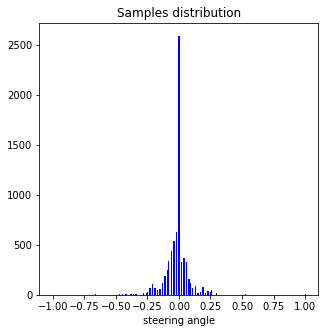

shape of sample set: (7350, 2)
Samples labeling - mean: -0.013026369687074829, std: 0.10057891171663791, min: -0.7735849, max: 1.0


In [8]:
samples = []

with open('./data/driving_log.csv', 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if row[3] == 'steering': 
                print(row)
            else:
                img_center = row[0].split("\\")[-1]
                img_center = img_center.split("/")[-1]
                steering_center = float(row[3])
                samples.append([img_center, steering_center])

samples = np.array(samples)

samples_view(samples)

center_2017_03_14_17_01_22_612.jpg
Shape of image: (160, 320, 3)


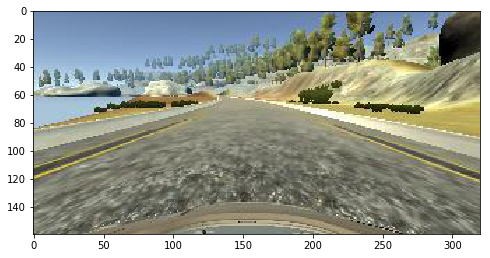

In [9]:
ex_name = samples[0,0]
print(ex_name)
ex_image = imread("./data/IMG/" + ex_name)
plt.figure(figsize=(8,8))
plt.imshow(ex_image)
print('Shape of image: {}'.format(ex_image.shape))

input_shape = ex_image.shape # Image shape

Shape of image: (80, 220, 3)


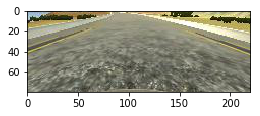

In [10]:
crop_img = ex_image[60:-20, 50:-50]
plt.figure(figsize=(4,4))
plt.imshow(crop_img)
print('Shape of image: {}'.format(crop_img.shape))

In [11]:
model = Sequential()
model.add(Cropping2D(cropping=((60,20), (50,50)), input_shape=input_shape))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))
model.add(Convolution2D(5,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(10,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(20,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(30,3,3, activation="relu"))
model.add(Convolution2D(30,3,3, activation="relu"))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 80, 220, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 80, 220, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 76, 216, 5)    380         lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 38, 108, 5)    0           convolution2d_1[0][0]            
___________________________________________________________________________________________

Shape of image: (160, 320, 3)
dtype of image: uint8


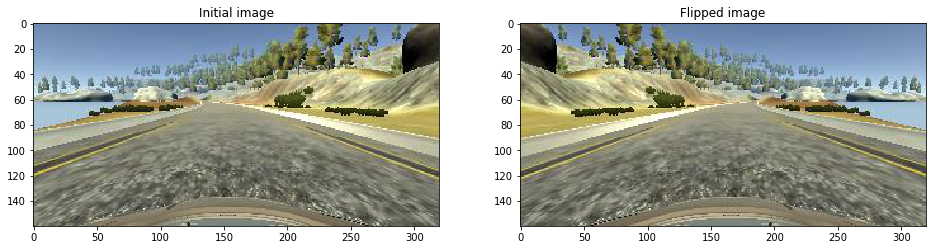

In [12]:
flipped_image = np.fliplr(ex_image)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('Initial image')
plt.imshow(ex_image)
plt.subplot(122)
plt.title('Flipped image')
plt.imshow(flipped_image)
print('Shape of image: {}'.format(flipped_image.shape))
print('dtype of image: {}'.format(flipped_image.dtype))

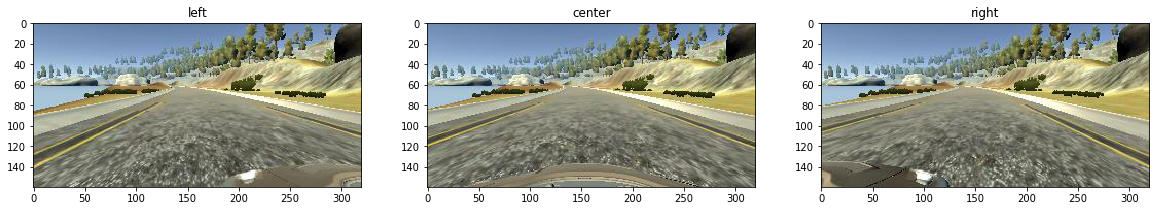

In [13]:
plt.figure(figsize=(20,8))
plt.subplot(131)
plt.title('left')
plt.imshow(imread('./data/IMG/' + ex_name.replace('center', 'left')))
plt.subplot(132)
plt.title('center')
plt.imshow(imread('./data/IMG/' + ex_name))
plt.subplot(133)
plt.title('right')
plt.imshow(imread('./data/IMG/' + ex_name.replace('center', 'right')))

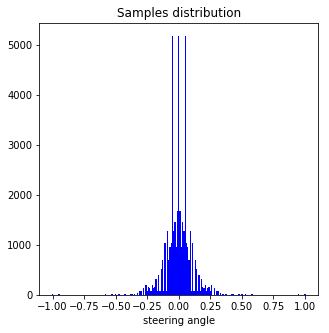

shape of sample set: (44100, 2)
Samples labeling - mean: -2.517512527494686e-21, std: 0.10907194021868814, min: -1.0, max: 1.0


In [14]:
correction = 0.05

samples = []

with open('./data/driving_log.csv', 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if row[3] == 'steering': 
                print(row)
            else:
                img_center = row[0].split("\\")[-1]
                img_center = img_center.split("/")[-1]
                img_left = row[1].split("\\")[-1]
                img_left = img_left.split("/")[-1]
                img_right = row[2].split("\\")[-1]
                img_right = img_right.split("/")[-1]
            
                img_center_flipped = 'flipped_' + img_center
                img_left_flipped = 'flipped_' + img_left
                img_right_flipped = 'flipped_' + img_right
            
                steering_center = float(row[3])
                steering_left = steering_center + correction
                steering_right = steering_center - correction
                if steering_left > 1.:
                    steering_left = 1.
                if steering_right < -1.:
                    steering_right = -1.
            
                steering_center_flipped = -steering_center
                steering_left_flipped = -steering_left
                steering_right_flipped = -steering_right
            
                samples.append([img_center, steering_center])
                samples.append([img_left, steering_left])
                samples.append([img_right, steering_right])
                samples.append([img_center_flipped, steering_center_flipped])
                samples.append([img_left_flipped, steering_left_flipped])
                samples.append([img_right_flipped, steering_right_flipped])

samples = np.array(samples)

samples_view(samples)

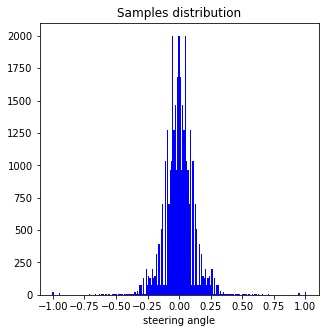

shape of sample set: (34542, 2)
Samples labeling - mean: 2.3141699314750525e-19, std: 0.12135651110748427, min: -1.0, max: 1.0


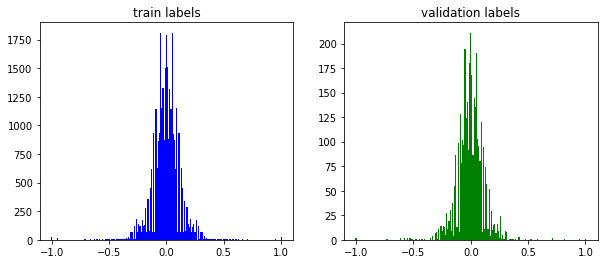

shape of train sample set: (31087, 2)
shape of validation sample set: (3455, 2)
Train labeling - mean: 0.0002171629552546077, std: 0.12181756305363747, min: -1.0, max: 1.0
Validation labeling - mean: -0.0019539637597684517, std: 0.11710839921442384, min: -1.0, max: 1.0


In [15]:
shuffle(samples)
i1, i2, i3 = 0, 0, 0
new_samples = []
for sample in samples:
    if float(sample[1]) == 0.:
        if i1 < 2000:
            i1 += 1
            new_samples.append(sample)
            
    elif float(sample[1]) == correction:
        if i2 < 2000:
            i2 += 1
            new_samples.append(sample)
        
    elif float(sample[1]) == -correction:
        if i3 < 2000:
            i3 += 1
            new_samples.append(sample)
            
    else:
        new_samples.append(sample)
            
samples = np.array(new_samples)
        
samples_view(samples)
train_samples, validation_samples = split_samples(samples)

Epoch 1/20
65s - loss: 0.0064 - val_loss: 0.0048
Epoch 2/20
62s - loss: 0.0058 - val_loss: 0.0048
Epoch 3/20
62s - loss: 0.0050 - val_loss: 0.0046
Epoch 4/20
62s - loss: 0.0044 - val_loss: 0.0048
Epoch 5/20
61s - loss: 0.0040 - val_loss: 0.0034
Epoch 6/20
63s - loss: 0.0036 - val_loss: 0.0036
Epoch 7/20
62s - loss: 0.0033 - val_loss: 0.0036
Epoch 8/20
62s - loss: 0.0033 - val_loss: 0.0034
Epoch 9/20
62s - loss: 0.0032 - val_loss: 0.0037
Epoch 10/20
62s - loss: 0.0030 - val_loss: 0.0030
Epoch 11/20
62s - loss: 0.0027 - val_loss: 0.0025
Epoch 12/20
62s - loss: 0.0026 - val_loss: 0.0031
Epoch 13/20
63s - loss: 0.0024 - val_loss: 0.0029
Epoch 14/20
62s - loss: 0.0023 - val_loss: 0.0026
Epoch 15/20
62s - loss: 0.0021 - val_loss: 0.0026
Epoch 16/20
62s - loss: 0.0021 - val_loss: 0.0026
Epoch 17/20
61s - loss: 0.0020 - val_loss: 0.0025
Epoch 18/20
62s - loss: 0.0018 - val_loss: 0.0025
Epoch 19/20
61s - loss: 0.0017 - val_loss: 0.0029
Epoch 20/20
62s - loss: 0.0020 - val_loss: 0.0024


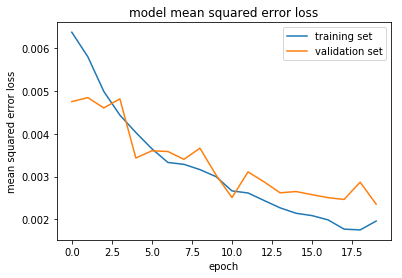

In [ ]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

model.compile(loss='mse', optimizer='adam')
history = model.fit_generator(train_generator, samples_per_epoch= len(train_samples),
                              validation_data=validation_generator, nb_val_samples=len(validation_samples), 
                              nb_epoch=20, verbose = 2)

training_plot(history)

In [ ]:
evaluate(validation_samples)

In [ ]:
imodel = 1
model.save('model{}.h5'.format(imodel))
print('model saved')

In [ ]:
def translation(image, tx):
    M = np.float32([[1,0,tx],[0,1,0]])
    dst = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return dst

imagetr_l = translation(imread("./data/IMG/"+ ex_image_name), -160)
imagetr_r = translation(imread("./data/IMG/"+ ex_image_name), 160)
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('Initial image')
plt.imshow(imread("./data/IMG/"+ ex_image_name))
plt.subplot(132)
plt.title('Translate from 160 px to left side')
plt.imshow(imagetr_l)
plt.subplot(133)
plt.title('Translate from 160 px to right side')
plt.imshow(imagetr_r)
print('Shape of image: {}'.format(imagetr_l.shape))
print('dtype of image: {}'.format(imagetr_l.dtype))
print(imagetr_l.min(), imagetr_l.max())

In [ ]:
new_samples = []
for sample in samples:
    #random = randint(-150,150)
    translatedl_img = 'ltranslated_' + sample[0]
    translatedl_steering = float(sample[1]) - 0.01
    translatedr_img = 'rtranslated_' + sample[0]
    translatedr_steering = float(sample[1]) + 0.01
    new_samples.append(sample)
    new_samples.append([translatedl_img, translatedl_steering])
    new_samples.append([translatedr_img, translatedr_steering])
    
samples = np.array(new_samples)

plt.figure(figsize=(5, 5))
plt.hist(samples[:,1].astype(float), bins, facecolor = 'b', label = 'Training Label')
plt.show()
print('shape of sample set: {}'.format(samples.shape))
print('Samples labeling - mean: {}, std: {}, min: {}, max: {}'.format(samples[:,1].astype(float).mean(),
                                                                      samples[:,1].astype(float).std(),
                                                                      samples[:,1].astype(float).min(),
                                                                      samples[:,1].astype(float).max()))    

In [ ]:
ex_image = cv2.GaussianBlur(ex_image, (3,3), 0)
plt.figure(figsize=(8,8))
plt.imshow(ex_image)
print('Shape of image: {}'.format(ex_image.shape))
print('dtype of image: {}'.format(ex_image.dtype))
print(ex_image.min(), ex_image.max())

In [ ]:
model = load_model('model{}.h5'.format(imodel))
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

model.compile(loss='mse', optimizer='adam')
history = model.fit_generator(train_generator, samples_per_epoch= len(train_samples),
                              validation_data=validation_generator, nb_val_samples=len(validation_samples), 
                              nb_epoch=20, verbose = 2)

training_plot(history)

In [ ]:
ex_image = cv2.cvtColor(ex_image, cv2.COLOR_BGR2YUV)
plt.figure(figsize=(8,8))
plt.imshow(ex_image)
print('Shape of image: {}'.format(ex_image.shape))
print('dtype of image: {}'.format(ex_image.dtype))
print(ex_image.min(), ex_image.max(),)

In [ ]:
plt.figure(figsize=(5, 5))
plt.hist(samples[:,1].astype(float), bins, facecolor = 'b', label = 'Training Label')
plt.show()
print('Samples labeling - mean: {}, std: {}, min: {}, max: {}'.format(samples[:,1].astype(float).mean(),
                                                                      samples[:,1].astype(float).std(),
                                                                      samples[:,1].astype(float).min(),
                                                                      samples[:,1].astype(float).max()))

In [ ]:
print(np.unique(samples[:,1].astype(float), return_counts=True))

In [ ]:
shuffle(samples)
i = 0
new_samples = []
for sample in samples:
    if -0.01 < float(sample[1]) < 0.01 :
        if i < 800:
            new_samples.append(sample)
            i += 1
    else:
        new_samples.append(sample)
            
samples = np.array(new_samples)       

samples_view(samples)